In [2193]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
np.random.seed(100)

In [2194]:
pd.set_option('display.max_rows', 10)
DataFrameOrg=pd.read_csv('infarto.csv',delimiter=';')
DataFrameOrg

,id,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,9046,Masculino,67.0,0,1,Si,Privado,Urbana,228.69,36.6,Ex fumador,1
1,51676,Femenino,61.0,0,0,Si,Autonomo,Rural,202.21,NaN,Nunca,1
2,31112,Masculino,80.0,0,1,Si,Privado,Rural,105.92,32.5,Nunca,1
3,60182,Femenino,49.0,0,0,Si,Privado,Urbana,171.23,34.4,Fumador,1
4,1665,Femenino,79.0,1,0,Si,Autonomo,Rural,174.12,24.0,Nunca,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Femenino,80.0,1,0,Si,Privado,Urbana,83.75,NaN,Nunca,0
5106,44873,Femenino,81.0,0,0,Si,Autonomo,Urbana,125.20,40.0,Nunca,0
5107,19723,Femenino,35.0,0,0,Si,Autonomo,Rural,82.99,30.6,Nunca,0
5108,37544,Masculino,51.0,0,0,Si,Privado,Rural,166.29,25.6,Ex fumador,0


In [2195]:
DataFrame=DataFrameOrg.drop(columns=["id"])
DataFrame.isnull().sum()

genero                    0
edad                      0
hipertensión              0
enfermedad_coronaria      0
casado                    0
                       ... 
residencia                0
nivel_glucosa             0
bmi                     201
uso_tabaco                0
infarto                   0
Length: 11, dtype: int64

In [2196]:
DataFrameSinNa=DataFrame.dropna().copy()
DataFrameSinNa.dtypes
#DataFrameSinNa=DataFrameSinNa.loc[DataFrameSinNa['uso_tabaco']!='NSNC']

genero                   object
edad                    float64
hipertensión              int64
enfermedad_coronaria      int64
casado                   object
                         ...   
residencia               object
nivel_glucosa           float64
bmi                     float64
uso_tabaco               object
infarto                   int64
Length: 11, dtype: object

In [2197]:
listaAleatorio=np.arange(0,DataFrameSinNa.shape[0]).tolist()
indexA=[]
for x in range(DataFrameSinNa.shape[0]):
    valor=np.random.choice(listaAleatorio)
    indexA.append(valor)
    listaAleatorio.remove(valor)
DataFrameSinNa['indexA'] = indexA
DataFrameSinNa=DataFrameSinNa.sort_values(by=['indexA'])
DataFrameSinNa=DataFrameSinNa.drop(columns=["indexA"])

In [2198]:
DataFrameSinNa['genero'].value_counts()

Femenino     2897
Masculino    2011
Other           1
Name: genero, dtype: int64

In [2199]:
DataFrameSinNa['casado'].value_counts()

Si    3204
No    1705
Name: casado, dtype: int64

In [2200]:
DataFrameSinNa['trabajo'].value_counts()

Privado          2811
Autonomo          775
Menor de edad     671
Funcionario       630
Sin trabajo        22
Name: trabajo, dtype: int64

In [2201]:
DataFrameSinNa['residencia'].value_counts()

Urbana    2490
Rural     2419
Name: residencia, dtype: int64

In [2202]:
DataFrameSinNa['uso_tabaco'].value_counts()

Nunca         1852
NSNC          1483
Ex fumador     837
Fumador        737
Name: uso_tabaco, dtype: int64

In [2203]:
DNumeric=DataFrameSinNa.copy()
DNumeric['genero'] = DNumeric['genero'].astype('category')
DNumeric['casado'] = DNumeric['casado'].astype('category')
DNumeric['trabajo'] = DNumeric['trabajo'].astype('category')
DNumeric['residencia'] = DNumeric['residencia'].astype('category')
DNumeric['uso_tabaco'] = DNumeric['uso_tabaco'].astype('category')
DNumeric

,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
3757,Femenino,54.0,0,0,Si,Privado,Urbana,75.16,38.0,Nunca,0
2247,Masculino,14.0,0,0,No,Menor de edad,Rural,91.25,23.8,NSNC,0
38,Masculino,58.0,0,0,No,Privado,Rural,92.62,32.0,NSNC,1
348,Femenino,25.0,0,0,No,Privado,Rural,66.30,27.2,Nunca,0
2357,Masculino,62.0,0,0,Si,Privado,Urbana,145.37,33.3,NSNC,0
...,...,...,...,...,...,...,...,...,...,...,...
1417,Femenino,41.0,0,0,Si,Privado,Urbana,80.77,21.1,Nunca,0
33,Masculino,80.0,0,1,Si,Autonomo,Urbana,252.72,30.5,Ex fumador,1
4912,Femenino,80.0,0,0,Si,Privado,Urbana,73.89,26.7,Ex fumador,0
3446,Femenino,21.0,0,0,No,Privado,Urbana,88.51,20.5,Nunca,0


In [2204]:
DNumeric["genero"] = DNumeric["genero"].cat.codes
DNumeric["casado"] = DNumeric["casado"].cat.codes
DNumeric["trabajo"] = DNumeric["trabajo"].cat.codes
DNumeric["residencia"] = DNumeric["residencia"].cat.codes
DNumeric["uso_tabaco"] = DNumeric["uso_tabaco"].cat.codes
DNumeric.dtypes

genero                     int8
edad                    float64
hipertensión              int64
enfermedad_coronaria      int64
casado                     int8
                         ...   
residencia                 int8
nivel_glucosa           float64
bmi                     float64
uso_tabaco                 int8
infarto                   int64
Length: 11, dtype: object

In [2205]:
Dseparacion=DNumeric.copy()
y=Dseparacion.infarto
Dseparacion=Dseparacion.drop(columns=["infarto"])
y = np.array(y)
Ytotales=y.reshape(y.shape[0],1)
Ytotales

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [2206]:
x = Dseparacion.values #returns a numpy array
scaler = preprocessing.MinMaxScaler()
Xtotales = scaler.fit_transform(x)
Xtotales

array([[0.  , 0.66, 0.  , ..., 0.09, 0.32, 1.  ],
       [0.5 , 0.17, 0.  , ..., 0.17, 0.15, 0.67],
       [0.5 , 0.71, 0.  , ..., 0.17, 0.25, 0.67],
       ...,
       [0.  , 0.98, 0.  , ..., 0.09, 0.19, 0.  ],
       [0.  , 0.26, 0.  , ..., 0.15, 0.12, 1.  ],
       [0.5 , 0.98, 0.  , ..., 0.65, 0.24, 0.  ]])

In [2207]:
X, X_test, Y, Y_test = train_test_split(Xtotales,Ytotales, test_size=0.1)

In [2208]:
model=Sequential()

In [2209]:
model.add(Dense(200,input_dim=Dseparacion.shape[1],activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [2210]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [2211]:
hist=model.fit(X, Y,batch_size=32,validation_split=0.2, epochs=30)

Epoch 1/30
111/111 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9414 - val_loss: 0.0394 - val_accuracy: 0.9604
Epoch 2/30
111/111 [==============================] - 0s 676us/step - loss: 0.0432 - accuracy: 0.9559 - val_loss: 0.0387 - val_accuracy: 0.9604
Epoch 3/30
111/111 [==============================] - 0s 685us/step - loss: 0.0420 - accuracy: 0.9559 - val_loss: 0.0380 - val_accuracy: 0.9604
Epoch 4/30
111/111 [==============================] - 0s 676us/step - loss: 0.0411 - accuracy: 0.9559 - val_loss: 0.0380 - val_accuracy: 0.9604
Epoch 5/30
111/111 [==============================] - 0s 676us/step - loss: 0.0406 - accuracy: 0.9559 - val_loss: 0.0375 - val_accuracy: 0.9604
Epoch 6/30
111/111 [==============================] - 0s 694us/step - loss: 0.0401 - accuracy: 0.9559 - val_loss: 0.0369 - val_accuracy: 0.9604
Epoch 7/30
111/111 [==============================] - 0s 685us/step - loss: 0.0396 - accuracy: 0.9559 - val_loss: 0.0365 - val_accuracy: 0

In [2212]:
model.evaluate(X_test, Y_test)

16/16 [==============================] - 0s 562us/step - loss: 0.0345 - accuracy: 0.9633


[0.03448314219713211, 0.9633401036262512]

In [2213]:
model(X)

<tf.Tensor: shape=(4418, 1), dtype=float32, numpy=
array([[0.08],
       [0.04],
       [0.01],
       ...,
       [0.  ],
       [0.04],
       [0.04]], dtype=float32)>

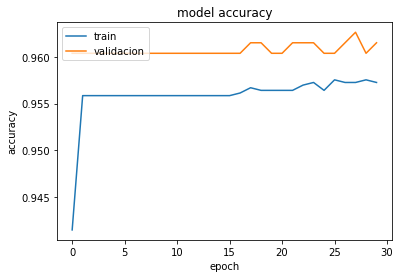

In [2214]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validacion'], loc='upper left')
plt.show()


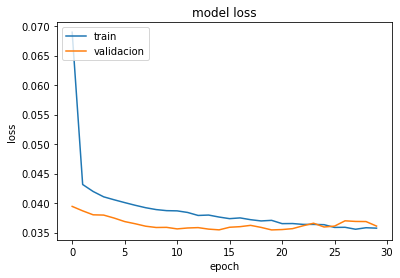

In [2215]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validacion'], loc='upper left')
plt.show()

In [2216]:
p=model(Xtotales)
p=p.numpy()
p2=p.round()
DataFrameSinNa['prediccion']=p
DataFrameSinNa['prediccion Round']=p2

In [2217]:
pd.set_option('display.max_rows', None)
Dtemporal=DataFrameSinNa.loc[(DataFrameSinNa['prediccion Round']==1.0) & (DataFrameSinNa['infarto']==1.0)]
Dtemporal

,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto,prediccion,prediccion Round
168,Femenino,79.0,1,0,No,Funcionario,Urbana,98.02,22.3,Ex fumador,1,0.519046,1.0
83,Femenino,68.0,1,0,No,Autonomo,Urbana,79.79,29.7,Nunca,1,0.563614,1.0
229,Femenino,80.0,1,0,No,Privado,Urbana,66.03,35.4,Nunca,1,0.631633,1.0
173,Femenino,80.0,1,0,Si,Autonomo,Rural,91.02,32.9,Ex fumador,1,0.531764,1.0
163,Femenino,78.0,1,0,No,Privado,Urbana,203.87,45.7,Nunca,1,0.589636,1.0
131,Femenino,78.0,1,0,No,Privado,Urbana,130.54,20.1,Nunca,1,0.707904,1.0
220,Masculino,81.0,1,1,Si,Privado,Urbana,250.89,28.1,Fumador,1,0.539704,1.0


In [2218]:
dlis=Dtemporal["prediccion"].tolist()
dlis=np.array(dlis)
print(dlis.shape)
print(dlis.mean())
Numeros1=DataFrameSinNa.loc[(DataFrameSinNa['infarto']==1.0)].shape[0]
(np.count_nonzero(p2)/Numeros1) *100

(7,)
0.5833286898476737


3.349282296650718

In [2267]:
Ypredict=p2
Ypredict = Ypredict.astype(np.int64)
labl=[1,0]
matrix = confusion_matrix(Ytotales.flatten(), Ypredict.flatten(),labels=labl)
matrix

array([[   7,  202],
       [   0, 4700]], dtype=int64)

[[   7  202]
 [   0 4700]]


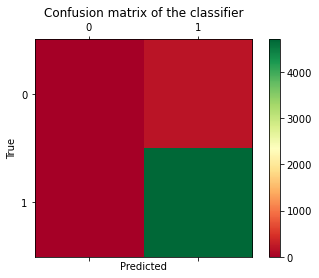

In [2274]:
#mostramos la matriz de confusion pintada y le pasamos en ytest y pred los valores
#q tenia q dar y los q da 

y_test = Ytotales.ravel()

pred = Ypredict.ravel()

print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix,cmap='RdYlGn')
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(labl)
ax.set_yticks(labl)
ax.set_xticklabels(labl)
ax.set_yticklabels(labl)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()



![title](a.png)